In [1]:
import pytesseract
import cv2
import sys
import numpy as np
from skimage import io
import manga109api
import matplotlib.pyplot as plt
from skimage import color

In [2]:
manga109_root = "../datasets/Manga109/Manga109_released_2021_12_30"
dataset = manga109api.Parser(manga109_root)

In [14]:
book = "ARMS"
page = dataset.get_annotation(book)["page"][5]
i, text = list(enumerate(page["text"]))[0]
image = io.imread("../datasets/Manga109/Manga109_released_2021_12_30/scaled_text_images/" + book + "/%03d_%03d.jpg" % (page["@index"], i))

In [15]:
import random
import skimage
from distutils.version import LooseVersion


def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True,
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize().

    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version
    of skimage. This solves the problem by using different parameters per
    version. And it provides a central place to control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Default it to False for backward
        # compatibility with skimage 0.13.
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range, anti_aliasing=anti_aliasing,
            anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return skimage.transform.resize(
            image, output_shape,
            order=order, mode=mode, cval=cval, clip=clip,
            preserve_range=preserve_range)
def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.

    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.

    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(255, 255), (255, 255), (255, 255)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = resize(image, (round(h * scale), round(w * scale)),
                       preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop

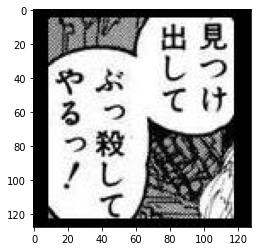

In [16]:
plt.imshow(image)

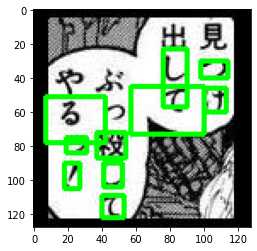

In [38]:
tess_config = "-l jpn_vert --psm 5 --oem 1 -c chop_enable=T -c use_Newstate_cost=F"
book = "ARMS"
page = dataset.get_annotation(book)["page"][5]
i, text = list(enumerate(page["text"]))[0]
image = io.imread("../datasets/Manga109/Manga109_released_2021_12_30/scaled_text_images/" + book + "/%03d_%03d.jpg" % (page["@index"], i))

h, w = image.shape[1:]
d = pytesseract.image_to_data(image, config=tess_config, output_type=pytesseract.Output.DICT)
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(image)
plt.show()

In [39]:
"".join(d['text'])

'見つけ<アー出して措選||ぶっ秋して本やるっ/の』'

In [28]:
"".join(d['text'])

'見つけ<アー出して措選||ぶっ秋して本やるっ/の』'